# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109A Introduction to Data Science


## Lab 4: Principle Component Analysis (PCA), Decision Trees And Random Forests

**Harvard University**<br>
**Summer 2020**<br>
**Contributors:** Will Claybaugh, David Sondak, Chris Tanner, Arpit Panda

---

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Table of Contents

<ol start="0">
  <li> Learning Goals </li>
  <li> Principal Components Analysis </li>
  <li> Classification Regression Trees </li>
  <li> Random Forests </li>
</ol>

##### Learning Goals
In this lab, we will look at how to use PCA to reduce a dataset to a smaller number of dimensions. The goal is for students to:
<ul>
  <li>Understand what PCA is and why it's useful</li>
  <li>Feel comfortable performing PCA on a new dataset</li>
  <li>Understand what it means for each component to capture variance from the original dataset</li>
  <li>Be able to extract the `variance explained` by components.</li>
  <li>Perform modeling with the PCA components</li>
  <li>Be able to fit and visualize decision trees and random forests</li>
  <li>Learn to use cross-validation to tune hyperperameters for these models</li>
  <li>Have a general understanding of the differences between the two tree methods and use cases</li>
</ul>  

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import accuracy_score
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

from sklearn.model_selection import train_test_split

## Part 1a:  PCA Review

What is PCA? PCA is a deterministic technique to transform data to a lowered dimensionality, whereby each feature/dimension captures the most variance possible.

Why do we care to use it?
<ul>
  <li>Visualizating the components can be useful</li>
  <li>Allows for more efficient use of resources (time, memory)</li>
  <li>Statistical reasons: fewer dimensions -> better generalization</li>
  <li>noise removal / collinearity (improving data quality)</li>
</ul>  

Imagine some dataset where we have two features that are pretty redundant. For example, maybe we have data concerning elite runners. Two of the features may include ``VO2 max`` and ``heartrate``. These are highly correlated. We probably don't need both, as they don't offer much additional information from each other. Using a [great visual example from online](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues), let's say that this unlabelled graph **(always label your axis)** represents those two features:

![VO2 Max vs Heart Rate](original_data.png)

Let's say that this is our entire dataset, just 2 dimensions. If we wish to reduce the dimensions, we can only reduce it to just 1 dimension. A straight line is just 1 dimension (to help clarify this: imagine your straight line as being the x-axis, and values can be somewhere on this axis, but that's it. There is no y-axis dimension for a straight line). So, how should PCA select a straight line through this data?

Below, the image shows all possible projects that are centered in the data:

![Animation of possible lines](animation.gif)

PCA picks the line that:
<ul>
<li>captures the most variance possible</li>
<li>minimizes the distance of the transformed points (distance from the original to the new space)</li>
</ul>

The animation **suggests** that these two aspects are actually the same. In fact, this is objectively true, but the proof for which is beyond the scope of the material for now. Feel free to read more at [this explanation](https://stats.stackexchange.com/questions/32174/pca-objective-function-what-is-the-connection-between-maximizing-variance-and-m/136072#136072) and via [Andrew Ng's notes](http://cs229.stanford.edu/notes/cs229-notes-all/cs229-notes10.pdf).

In short, PCA is a math technique that works with the covariance matrix -- the matrix that describes how all pairwise features are correlated with one another. Covariance of two variables measures the degree to which they moved/vary in the same direction; how much one variable affects the other. A positive covariance means they are positively related (i.e., x1 increases as x2 does); negative means negative correlation (x1 decreases as x2 increases).

In data science and machine learning, our models are often just finding patterns in the data this is easier if the data is spread out across each dimension and for the data features to be independent from one another (imagine if there's no variance at all. We couldn't do anything). Can we transform the data into a new set that is a linear combination of those original features?

PCA finds new dimensions (set of basis vectors) such that all the dimensions are orthogonal and hence linearly independent, and ranked according to the variance (eigenvalue). That is, the first component is the most important, as it captures the most variance.

## Part 1b:  Intro to the Wine Dataset

Imagine that a wine sommelier has tasted and rated 1,000 distinct wines, and now that she's highly experienced, she is curious if she can more efficiently rate wines without even trying them. That is, perhaps her tasting preferences follow a pattern, allowing her to predict the rating a new wine without even trying it!  

The dataset contains 11 chemical features, along with a quality scale from 1-10; however, only values of 3-9 are actually used in the data. The ever-elusive perfect wine has yet to be tasted. 

#### **NOTE:** While this dataset involves the topic of alcohol, we, the CS109A staff, along with Harvard at large is in no way encouraging alcohol use, and this example should not be intrepreted as any endorsement for such; it is merely a pedagogical example. I apologize if this example offends anyone or is off-putting.



### Read-in and checking
First, let's read-in the data and verify it:

In [3]:
wines_df = pd.read_csv("./data/wines.csv", index_col=0)
wines_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red
0,8.9,0.590,0.50,2.0,0.337,27.0,81.0,0.99640,3.04,1.61,9.5,6,1
1,7.7,0.690,0.22,1.9,0.084,18.0,94.0,0.99610,3.31,0.48,9.5,5,1
2,8.8,0.685,0.26,1.6,0.088,16.0,23.0,0.99694,3.32,0.47,9.4,5,1
3,11.4,0.460,0.50,2.7,0.122,4.0,17.0,1.00060,3.13,0.70,10.2,5,1
4,8.8,0.240,0.54,2.5,0.083,25.0,57.0,0.99830,3.39,0.54,9.2,5,1


In [4]:
wines_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,7.558400,0.397455,0.30676,4.489250,0.067218,25.29650,91.03100,0.995351,3.251980,0.572990,10.489433,5.796000,0.50000
std,1.559455,0.189923,0.16783,4.112419,0.046931,17.06237,59.57269,0.002850,0.164416,0.169583,1.151195,0.844451,0.50025
min,3.800000,0.080000,0.00000,0.800000,0.009000,1.00000,6.00000,0.987400,2.740000,0.280000,8.500000,3.000000,0.00000
25%,6.500000,0.260000,0.22000,1.800000,0.042000,12.00000,37.75000,0.993480,3.140000,0.460000,9.500000,5.000000,0.00000
50%,7.200000,0.340000,0.30000,2.400000,0.060000,22.00000,86.00000,0.995690,3.240000,0.550000,10.300000,6.000000,0.50000
75%,8.200000,0.520000,0.40000,6.100000,0.080000,35.00000,135.00000,0.997400,3.360000,0.650000,11.300000,6.000000,1.00000
max,15.500000,1.580000,1.00000,26.050000,0.611000,131.00000,313.00000,1.003690,3.900000,2.000000,14.000000,8.000000,1.00000


For this exercise, let's say that the wine expert is curious if she can predict, as a rough approximation, the **categorical quality -- bad, average, or great.** Let's define those categories as follows:

- `bad` is when for wines that have a quality <= 5
- `average` is when a wine has a quality of 6 or 7
- `great` is when a wine has a quality of >= 8

In [5]:
# copy the original data so that we're free to make changes
wines_df_recode = wines_df.copy()

# use the 'cut' function to reduce a variable down to the aforementioned bins (inclusive boundaries)
wines_df_recode['quality'] = pd.cut(wines_df_recode['quality'],[0,5,7,10], labels=[0,1,2])
wines_df_recode.loc[wines_df_recode['quality'] == 1]

# drop the un-needed columns
x_data = wines_df_recode.drop(['quality'], axis=1)
y_data = wines_df_recode['quality']

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=.2, random_state=8, stratify=y_data)

# previews our data to check if we correctly constructed the labels (we did)
print(wines_df['quality'].head())
print(wines_df_recode['quality'].head())

0    6
1    5
2    5
3    5
4    5
Name: quality, dtype: int64
0    1
1    0
2    0
3    0
4    0
Name: quality, dtype: category
Categories (3, int64): [0 < 1 < 2]


For sanity, let's see how many wines are in each category:

In [6]:
y_data.value_counts()


1    598
0    379
2     23
Name: quality, dtype: int64

Now that we've split the data, let's look to see if there are any obvious patterns (correlations between different variables).

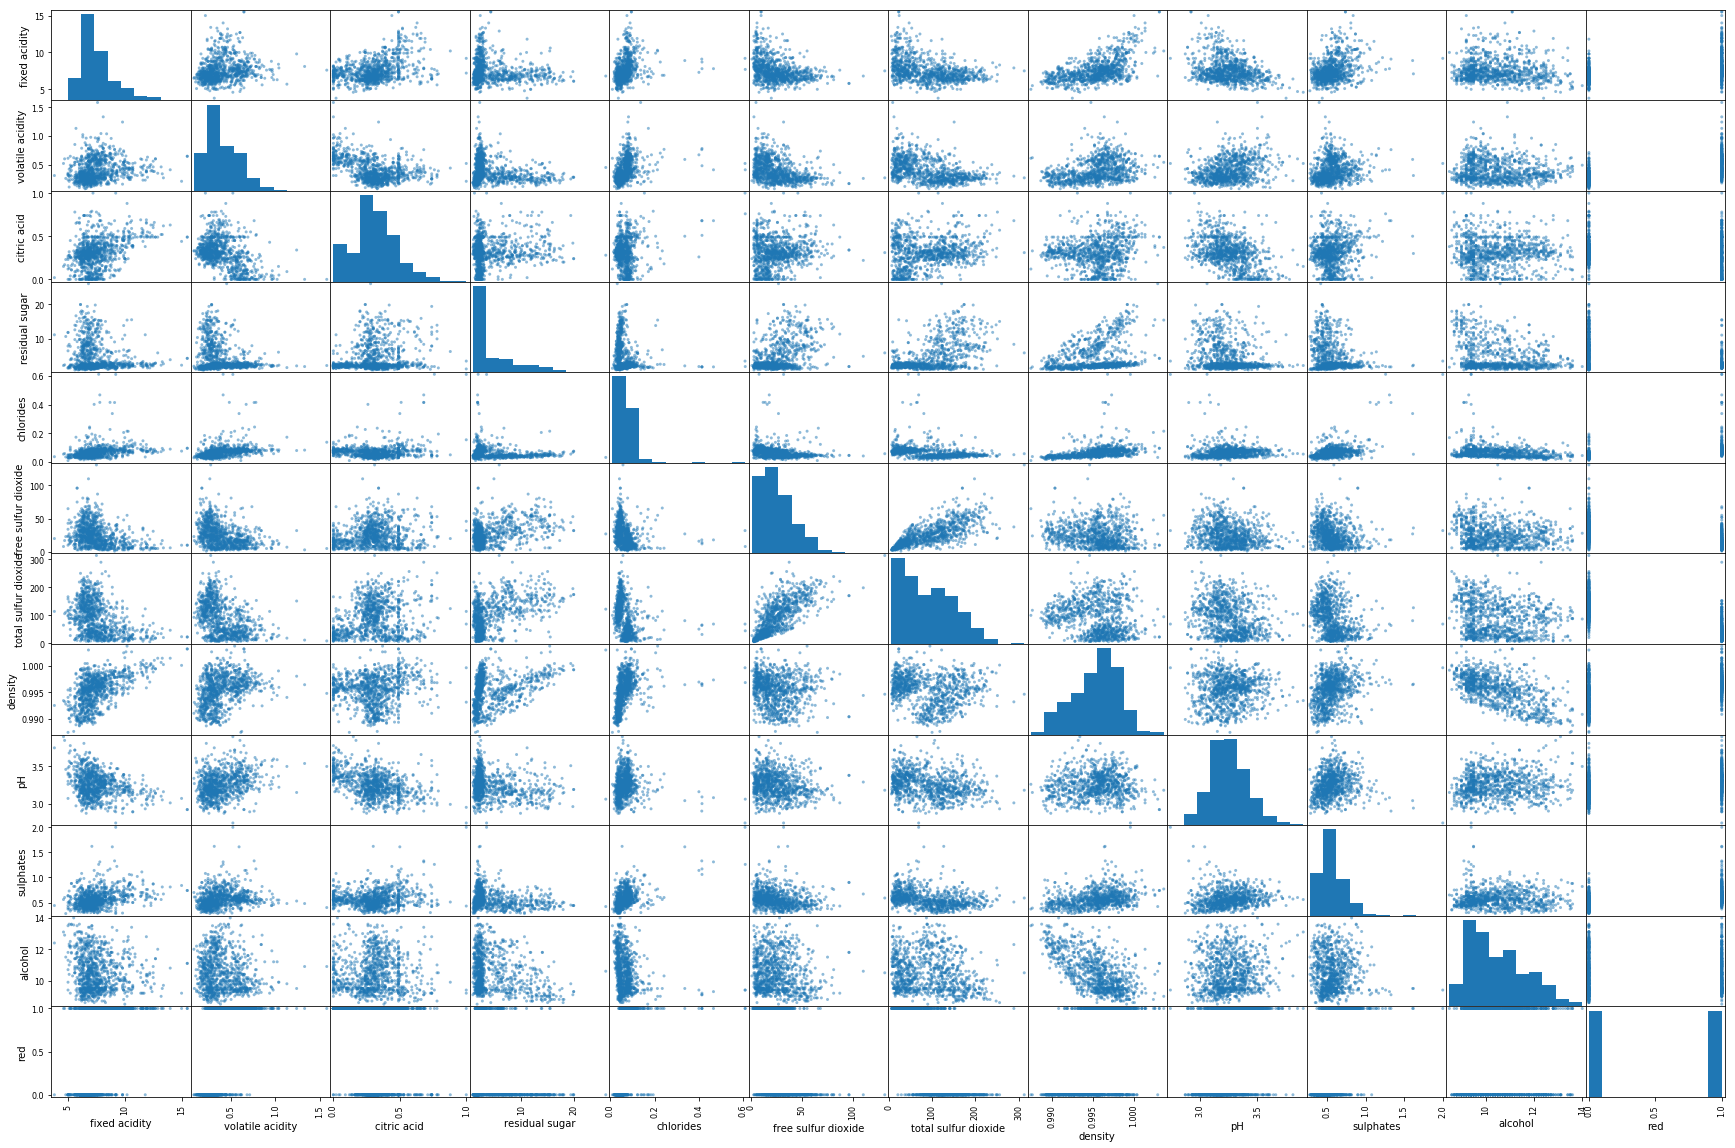

In [7]:
from pandas.plotting import scatter_matrix
scatter_matrix(wines_df_recode, figsize=(30,20));

## Part 1c: Dimensionality Reduction
In attempt to improve performance when we model our data, we may wonder if some of our features are redundant and are posing difficulties for our logistic regression model. Let's PCA to shrink the problem down to 2 dimensions (with as little loss as possible) and see if that gives us a clue about what makes this problem tough.

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

num_components = 2


# scale the datasets
scale_transformer = StandardScaler(copy=True).fit(x_train)
x_train_scaled = scale_transformer.transform(x_train)
x_test_scaled = scale_transformer.transform(x_test)

# reduce dimensions
pca_transformer = PCA(num_components).fit(x_train_scaled)
x_train_2d = pca_transformer.transform(x_train_scaled)
x_test_2d =  pca_transformer.transform(x_test_scaled)

print(x_train_2d.shape)
x_train_2d[0:5,:]


(800, 2)


array([[-1.23949587, -2.34876616],
       [-1.13615842,  0.37632328],
       [ 1.84037474, -0.10597198],
       [ 2.00455608, -0.14333293],
       [ 1.68553308,  4.82627254]])

**NOTE:**
1. Both scaling and reducing dimension follow the same pattern: we fit the object to the training data, then use .transform() to convert the training and test data. This ensures that, for instance, we scale the test data using the _training_ mean and variance, not its own mean and variance
2. We need to equalize the variance of each feature before applying PCA; otherwise, certain dimensions will dominate the scaling. Our PCA dimensions would just be the features with the largest spread.

<div class="exercise"><b>Exercise 1.1:</b> Why didn't we scale the y-values (class labels) or transform them with PCA? Is this a mistake?</div>


*Your Answer*

<div class="exercise"><b>Exercise 1.2:</b> Our data only has 2 dimensions/features now. What do these features represent?</div>

*Your Answer*

Since our data only has 2 dimensions now, we can easily visualize the entire dataset. If we choose to color each datum with respect to its associated label/class, it allows us to see how separable the data is. That is, it gives an indication as to how easy/difficult it is for a model to fit the new, transformed data.

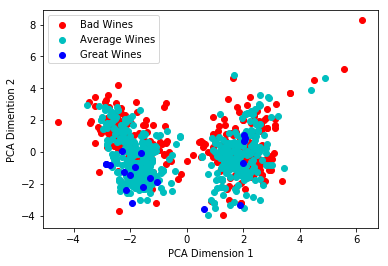

In [11]:
# notice that we set up lists to track each group's plotting color and label
colors = ['r','c','b']
label_text = ["Bad Wines", "Average Wines", "Great Wines"]

# and we loop over the different groups
for cur_quality in [0,1,2]:
    cur_df = x_train_2d[y_train==cur_quality]
    plt.scatter(cur_df[:,0], cur_df[:,1], c = colors[cur_quality], label=label_text[cur_quality])

# all plots need labels
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimention 2")
plt.legend();

Well, that gives us some idea of why the problem is difficult! The bad, average, and great wines are all on top of one another. Not only are there few great wines, which we knew from the beginning, but there is no line that can easily separate the classes of wines.

<div class="exercise"><b>Exercise 1.3:</b></div>

<ol>
  <li>What critique can you make against the plot above? Why does this plot not prove that the different wines are hopelessly similar?</li>
  <li>The wine data we've used so far consist entirely of continuous predictors. Would PCA work with categorical data?</li>
</ol>

In [12]:
# Your answer

Looking at our PCA plot above, we see something peculiar: we have two disjoint clusters, both of which have immense overlap in the qualities of wines.

<div class="exercise"><b>Exercise1.4:</b> What could cause this? What does this mean?</div>

In [13]:
# answer was discussed in lab

<div class="exercise"><b>Exercise1.5:</b> Let's plot the same PCA'd data, but let's color code them according to if the wine is red or white. Does this graph help you answer our previous question? Does it change your thoughts?</div>


In [14]:
# answer was discussed in lab

## Part 1d. Evaluating PCA: Variance Explained And Predictions
One of the criticisms we made of the PCA plot was that it's lost something from the original data. Heck, we're only using 2 dimensions, we it's perfectly reasonable and expected for us to lose some information -- our goal was that the information we were discarding was noise.

Let's investigate how much of the original data's structure the 2-D PCA captures. We'll look at the `explained_variance_ratio_` portion of the PCA fit. This lists, in order, the percentage of the x data's total variance that is captured by the nth PCA dimension.

In [15]:
var_explained = pca_transformer.explained_variance_ratio_
print("Variance ok idexplained by each PCA component:", var_explained)
print("Total Variance Explained:", np.sum(var_explained))

Variance ok idexplained by each PCA component: [0.34021651 0.20128374]
Total Variance Explained: 0.5415002511091701


The first PCA dimension captures 33% of the variance in the data, and the second PCA dimension adds another 20%. Together, we've captured about half of the total variation in the training data with just these two dimensions. So far, we've used PCA to transform our data, we've visualized our newly transformed data, and we've looked at the variance that it captures from the original dataset. That's a good amount of inspection; now let's actually use our transformed data to make predictions.



<div class="exercise"><b>Exercise 1.6:</b> Use Logistic Regression (with and without cross-validation) on the PCA-transformed data.Logistic regression was performed on original data and accuracy of approximately 75% was achieved. Before you generate an answer, do you expect to outperform the 75% with PCA transformed data. What are your actual results? Does this seem reasonable? .</div>

In [47]:
#Your answer

We're only using 2 dimensions. What if we increase our data to 10 PCA components?

<div class="exercise"><b>Exercise 1.7:</b></div>
<ol>
  <li>Fit a PCA that finds the first 10 PCA components of our training data</li>
  <li>Use `np.cumsum()` to print out the variance we'd be able to explain by using n PCA dimensions for n=1 through 10</li>
  <li>Does the 10-dimension PCA agree with the 2d PCA on how much variance the first components explain? **Do the 10d and 2d PCAs find the same first two dimensions? Why or why not?**</li>
    <li>Make a plot of number of PCA dimensions against total variance explained. What PCA dimension looks good to you?</li>
</ol> 

Hint: `np.cumsum` stands for 'cumulative sum', so `np.cumsum([1,3,2,-1,2])` is `[1,4,6,5,7]`

In [16]:
# Your answer

The plot above can be used to inform of us when we reach diminishing returns on variance explained. That is, the 'elbow' of the line is probably an ideal number of dimensions to use, at least with respect to the amount of variance explained.

<br>

<div class="exercise"><b>Exercise 1.8:</b> Looking at your graph, what is the 'elbow' point / how many PCA components do you think we should use? Does this number of components imply that predictive performance will be optimal at this point? Why or why not?</div>

In [46]:
#Your answer

## Part 1e: PCA Debriefing:

- PCA maps a high-dimensional space into a lower dimensional space.
- The PCA dimensions are ordered by how much of the original data's variance they capture
    - There are other cool and useful properties of the PCA dimensions (orthogonal, etc.). See a [textbook](http://math.mit.edu/~gs/linearalgebra/).
- PCA on a given dataset always gives the same dimensions in the same order.
- You can select the number of dimensions by fitting a big PCA and examining a plot of the cumulative variance explained.

PCA is not guaranteed to improve predictive performance at all. As you've learned in class now, none of our models are guaranteed to always outperform others on all datasets; analyses are a roll of the dice. The goal is to have a suite of tools to allow us to gather, process, disect, model, and visualize the data -- and to learn which tools are better suited to which conditions. Sometimes our data isn't the most conducive to certain tools, and that's okay.

What can we do about it?
1. Be honest about the methods and the null result. Lots of analyses fail.
2. Collect a dataset you think has a better chance of success. Maybe we collected the wrong chemical signals...
3. Keep trying new approaches. Just beware of overfitting the data you're validating on. Always have a test set locked away for when the final model is built.
4. Change the question. Maybe something you noticed during analysis seems interesting or useful (classifying red versus white). But again, you the more you try, the more you might overfit, so have test data locked away.
5. Just move on. If the odds of success start to seem small, maybe you need a new project.

## Part 2: Classification Decision Trees 

Let's step back and remember why we use decision trees.  

Decision trees are a supervised learning method to perform both regression and classification. Given that decision trees don't make any distributional assumptions about the underlying data, and complexity can scale with training data size, they are a non-parametric method (recall other non-parametric methods we have learned like k-NN). Some benefits of Decision Trees:
1. Allow us to create more complex looking decision boundaries (than Logistic Regression's linear boundaries, for example)
2. Greater feature interpretability
3. Easy to use, no specific data transformations required (like polynomials, interaction terms, etc.)


### Basics of Building a Tree:

To build a decision tree:
<ul>
  <li>Start with an empty tree and some data: $y, X$</li>
  <li>Decide what your splitting criterion will be (e.g., Gini, Entropy, etc for classification)</li>
  <li>Decide what your what your stopping criterion will be, or if you'll develop a large tree and prune </li>
  <li>Build the tree in a greedy manner, and if you have multiple hyperparameters, use cross-validation to determine the best values</li>
</ul>  


Recall in class, we worked with a Decision Tree regressor to predict votergap in the 2016 election. Now, we will try our hand with a classification task. 

We will explore the Wines dataset which has 3 classes "Bad Wines", "Average Wines" and "Great Wines." This is a mult-class problem where we have 3 categories that have been defined as 0, 1 and 2 in our dataframes previously. 

In [70]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(max_depth = 5)
dtree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

<div class="exercise"><b>Exercise 2.1:</b> </div> Use the plot_tree command found in the sklearn.tree module to print out the tree. Interpret the printed out tree. To improve interpretability, consider using the class_names and feature_names arguments.

In [71]:
# Your Answer

<div class="exercise"><b>Exercise 2.2:</b> Modulate the tree complexity by choosing a range of tree depths from 1 to 20 and plot a few of these trees. What do you notice about the purity of leaves as tree depth increases? </div>

In [67]:
#Your answer

<div class="exercise"><b>Exercise 2.3:</b> Does choice of splitter matter? Choose a tree depth from the previous problem and try a different splitter to check how your classification gets affected. Give a short explanation of what Gini and Entropy do. </div>

In [68]:
#Your answer

<div class="exercise"><b>Exercise 2.4:</b> Perform 5-fold cross validation to determine what the best max_depth would be for a range of tree depths in [1,20]. Plot the estimated mean for +/- 2 standard deviation for each depth across validation sets. Select an appropriate depth and justify your choice. In your visualization, also plot training R^2. </div>

In [ ]:
# Your answer

<div class="exercise"><b>Exercise 2.5:</b> Report overall classification accuracy and the accuracies within each of the 3 classes of quality on the test dataset for best model from the previous exercise.  What do you notice?</div>

In [69]:
# Your answer

## Part 3: Random Forests

What's the basic idea?

As we discussed in lecture, one variance reducing method is to use bagging (bootstrap aggregating). Here, we boostrap the training data and build many trees from these bootstrapped samples, and then average over all the trees we built. Unfortunately, we might still retain a lot of overfitting. One alternative is to use Random Forests.

Here we will build each tree by splitting on "random" subset of predictors at each split (hence, each is a 'random tree').  This can't be done in with just one predictor, but with more predictors we can choose what predictors to split on randomly and how many to do this on.  Then we combine many 'random trees' together by averaging their predictions, and this gets us a forest of random trees: a **random forest**.

Parameters of interest to us:
```
max_features : int, float, string or None, optional (default=”auto”)
- The number of features to consider when looking for the best split.
```
- `max_features`: Default splits on all the features and is probably prone to overfitting. You'll want to validate on this. 

<div class="exercise"><b>Exercise 3.1: Fit a Random Forest Classifier to the training data using 15 as max depth and 50 trees. Start with max_features = sqrt(total_number of features). Determine $R^2$ in the test set for this model. </b> </div>

In [1]:
#Your answer

<div class="exercise"><b>Exercise 3.2: Use sklearn's RandomForestClassifier to fit a bagging model to the training data using 15 as max depth and 50 trees.  Determine $R^2$ in the test set for this model. How does this compare to the random forest in the previous part?</b> </div>

In [72]:
#Your answer

<div class="exercise"><b>Exercise 3.3: List at least 3 hyperparameters in Random Forest models? Which hyperameters need to be tuned? </b> </div>

In [ ]:
#Your answer

<div class="exercise"><b>Exercise 3.4: Play around with the max_features to improve accuracy on the test data. Report what you saw. </b> </div>

In [73]:
#Your answer

<div class="exercise"><b>Exercise 3.5: Now, take a systematic approach. Tune the num_estimators and max_features using GridSearch to discover the optimal RF model. Report the best model's $R^2$  </b> </div>

In [ ]:
param_dict2 = OrderedDict(
    n_estimators = [400,600,800],
    max_features = [0.2, 0.4, 0.6, 0.8]
)


In [ ]:
from sklearn.model_selection import GridSearchCV
est2 = RandomForestRegressor(oob_score=False)
gs = GridSearchCV(est2, param_grid = param_dict2, cv=3, n_jobs=-1)
gs.fit(X_train, y_train)

<div class="exercise"><b>Exercise 3.6: Plot the feature importances and interpret them for the best RF model you previously created. </b> </div>

In [ ]:
#Your answer

<div class="exercise"><b>Bonus Question:: What does the RF model you created say about the relationships between pH and alcohol level with the 3 wine quality classes? Provide three plots to support this interpretation: the predicted probabilities of the 3 classes vs. each of the two (2 scatterplots with predicted lines on them) and the decision boundary plot (or contour plot) to predict wine quality classes frmo the two predictors. </b> </div>

In [ ]:
#Your answer